# Forecast a multivariate time series

with TensorFlow 2.0

dataset: Brugge field .mat

## Setup

In [1]:
import numpy as np
from os.path import dirname, join as pjoin
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

DATA_PATH = '../data'
DATA_FILE_NAME = 'Brugge_en_d.mat'
RESULT_FILE_NAME = 'rmse_brugge.csv'

TRAIN_SPLIT = 150
BUFFER_SIZE = 1000
BATCH_SIZE = 32
EVALUATION_INTERVAL = 10
EPOCHS = 200

data_dir = pjoin(DATA_PATH, DATA_FILE_NAME)
mat_contents = sio.loadmat(data_dir)

data = mat_contents['en_d'][0, 0]

# tf.debugging.set_log_device_placement(True)

## Data Preparation

In [2]:
well_dic = {}

for well_index in range(20): # well, Producer P1-P20
    # 'model_num' => dataframe
    model_dic = {}
    well_key = 'P' + str(well_index+1)
    for model_index in range(104): # model, model 1-104
        well_data = np.array([
            data['WOPR'][0,0][well_key][:,model_index],
            data['WBHP'][0,0][well_key][:,model_index],
            data['WWCT'][0,0][well_key][:,model_index],
            data['WWPR'][0,0][well_key][:,model_index]
          ])
        # col1: WOPR, col2: WBHP, col3: WWCT, col4: WWPR
        # row1: day1, ... row 498: day3648
        well_data = well_data.T
        df = pd.DataFrame(data=well_data,
                          index=data['TIME'].flatten(),
                          columns=['WOPR', 'WBHP', 'WWCT', 'WWPR'])
        df.index.name = 'date'
        model_dic[str(model_index+1)] = df
        
    well_dic[str(well_index+1)] = model_dic

In [3]:
def plot_single_well(well_dic, well_num):
    ax = plt.gca()
    true_model_num = 103
    for i in range(104):
        df = well_dic[str(well_num)][str(i+1)]
        if i == true_model_num:
            df.plot(y='WBHP', ax=ax, color='red', legend=False)
        else:
            df.plot(y='WBHP', ax=ax, color='gray', legend=False)
            
    plt.show()

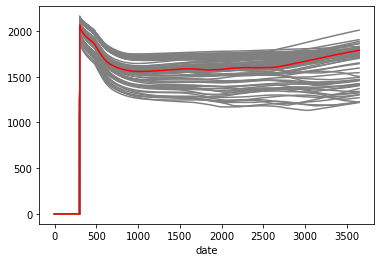

In [8]:
plot_single_well(well_dic, 19)

# Data Preprocessing

In [9]:
well_index = '19'
model_index = '15'

dataset = well_dic[well_index][model_index].values

print(f"WWCT shape: {dataset[:, 3].shape}")
# dataset[:, 3]

WWCT shape: (498,)


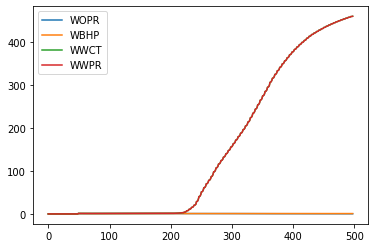

In [10]:
# data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
# data_std = dataset[:TRAIN_SPLIT].std(axis=0)

# dataset = (dataset-data_mean)/data_std

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(dataset[:TRAIN_SPLIT])
# dataset = scaler.transform(dataset)

# Replace StandardScaler with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(dataset[:TRAIN_SPLIT])
dataset = scaler.transform(dataset)

plt.plot(dataset[:, 0], label="WOPR")
plt.plot(dataset[:, 1], label="WBHP")
plt.plot(dataset[:, 2], label="WWCT")
plt.plot(dataset[:, 3], label="WWPR")
plt.legend()
plt.show()

In [52]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [53]:
past_history = 5
future_target = 0
STEP = 1

print(dataset.shape)

x_train_single, y_train_single = multivariate_data(dataset[:, :2], dataset[:, 0], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)

x_val_single, y_val_single = multivariate_data(dataset[:, :2], dataset[:, 0],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

print(x_train_single.shape, y_train_single.shape, x_val_single.shape, y_val_single.shape)

(498, 4)
(145, 5, 2) (145,) (343, 5, 2) (343,)


In [54]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_data_single = train_data_single.prefetch(1)
# train_data_single = train_data_single.prefetch(buffer_size=1)

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()
# val_data_single = val_data_single.prefetch(buffer_size=1)

# Define model and Train

In [55]:
lstm1_units = 50
lstm2_units = 50
gaussian_std = 0.1
dropout_rate = 0.2

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.GaussianNoise(gaussian_std, input_shape=x_train_single.shape[-2:]))
# single_step_model.add(tf.keras.layers.LSTM(lstm1_units, activation='relu', return_sequences=True,
#                                            input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.LSTM(lstm1_units, activation='relu',return_sequences=True))
single_step_model.add(tf.keras.layers.Dropout(dropout_rate))

single_step_model.add(tf.keras.layers.LSTM(lstm2_units, activation='relu', return_sequences = True))
single_step_model.add(tf.keras.layers.Dropout(dropout_rate))

single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer='adam', loss='mean_squared_error')

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, verbose=1)

In [56]:
single_step_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_3 (GaussianNo (None, 5, 2)              0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 5, 50)             10600     
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 5, 1)              51        
Total params: 30,851
Trainable params: 30,851
Non-trainable params: 0
__________________________________________________

In [57]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(32, 5, 1)


In [58]:
single_step_history = single_step_model.fit(
    train_data_single,
    epochs=EPOCHS,
    steps_per_epoch=TRAIN_SPLIT//BATCH_SIZE,
    validation_data=val_data_single,
    validation_steps=50,
    use_multiprocessing=True,
    workers=8,
    callbacks = [es]
)

Train for 4 steps, validate for 50 steps
Epoch 1/200
4/4 [==============================] - 4s 1s/step - loss: 0.7060 - val_loss: 0.5093
Epoch 2/200
4/4 [==============================] - 0s 120ms/step - loss: 0.6219 - val_loss: 0.4678
Epoch 3/200
4/4 [==============================] - 0s 116ms/step - loss: 0.6209 - val_loss: 0.4283
Epoch 4/200
4/4 [==============================] - 1s 126ms/step - loss: 0.5457 - val_loss: 0.3831
Epoch 5/200
4/4 [==============================] - 0s 119ms/step - loss: 0.4914 - val_loss: 0.3301
Epoch 6/200
4/4 [==============================] - 0s 120ms/step - loss: 0.4481 - val_loss: 0.2707
Epoch 7/200
4/4 [==============================] - 0s 118ms/step - loss: 0.3290 - val_loss: 0.2122
Epoch 8/200
4/4 [==============================] - 0s 119ms/step - loss: 0.2957 - val_loss: 0.1782
Epoch 9/200
4/4 [==============================] - 0s 113ms/step - loss: 0.2643 - val_loss: 0.1919
Epoch 10/200
4/4 [==============================] - 0s 118ms/step - los

In [59]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

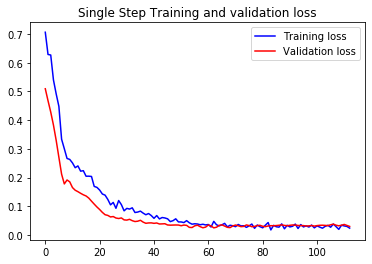

In [60]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

# Inference

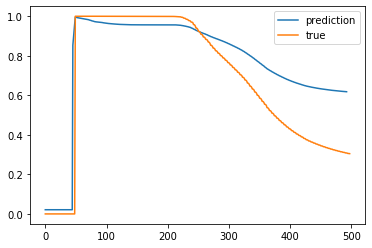

In [61]:
# Todo
# Temp plotting
# predict from training set
x_entire, _ = multivariate_data(dataset[:, :2], dataset[:, 0], 0,
                                                   None, past_history,
                                                   future_target, STEP,
                                                   single_step=True)

y_hat = single_step_model.predict(x_entire)
# print(y_hat[:,-1].shape)
# print(y_train_single.shape)
plt.plot(y_hat[:,-1], label='prediction')
plt.plot(dataset[:, 0], label='true')
plt.legend()
plt.show()

(343, 1)
(343,)


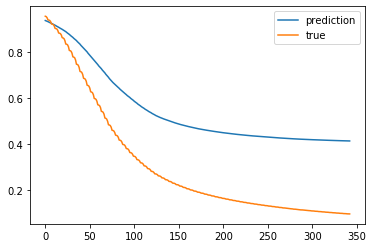

In [47]:
y_hat = single_step_model.predict(x_val_single)
# print(y_hat.shape)
print(y_hat[:,-1].shape)
print(y_val_single.shape)
# print(y_train_single.shape)
plt.plot(y_hat[:,-1], label='prediction')
plt.plot(y_val_single, label='true')
# plt.plot(dataset[TRAIN_SPLIT:][:,0], label='from_dataset')
plt.legend()
plt.show()

In [ ]:
scaler.min_

In [ ]:
scaler.scale_

In [ ]:
# Evalutate RMSE first and inverse trnasform
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse = sqrt(mean_squared_error(y_val_single, y_hat[:, -1]))
print('Test RMSE: %.3f' % rmse)

# mse = mean_squared_error(y_val_single, y_hat[:, -1])
# print('Test RMSE: %.3f' % mse)

In [ ]:
# single_feature_inverse = (y_hat[:, -1] - scaler.min_[0])/scaler.scale_[0]

In [ ]:
y_hat_inverse = (y_hat[:, -1] - scaler.min_[0])/scaler.scale_[0]
y_val_inverse = (y_val_single - scaler.min_[0])/scaler.scale_[0]
y_train_inverse = (y_train_single - scaler.min_[0])/scaler.scale_[0]

y_train_inverse = y_train_inverse.reshape((-1, 1))
y_predicted = np.concatenate((y_train_inverse, y_hat_inverse), axis = None)
y_true = np.concatenate((y_train_inverse, y_val_inverse.reshape((-1, 1))), axis = None)

In [ ]:
plt.plot(y_predicted, linestyle='-', label='prediction')
plt.plot(y_true, linestyle='-', label='true')
plt.xlabel('date')
plt.ylabel('WOPR')
plt.title('WOPR true vs prediction')
plt.legend()
plt.show()

In [ ]:
# Using StandardScaler
# y_hat_inverse = y_hat[:,-1] * np.sqrt(scaler.var_[0]) + scaler.mean_[0]
# y_val_inverse = y_val_single * np.sqrt(scaler.var_[0]) + scaler.mean_[0]
# y_train_inverse = y_train_single * np.sqrt(scaler.var_[0]) + scaler.mean_[0]

# y_train_inverse = y_train_inverse.reshape((-1, 1))
# y_predicted = np.concatenate((y_train_inverse, y_hat_inverse), axis = None)
# y_true = np.concatenate((y_train_inverse, y_val_inverse.reshape((-1, 1))), axis = None)

# plt.plot(y_predicted, linestyle='-', label='prediction')
# plt.plot(y_true, linestyle='-', label='true')
# plt.xlabel('date')
# plt.ylabel('WOPR')
# plt.title('WOPR true vs prediction')
# plt.legend()
# plt.show()

# Evaluate the model

In [ ]:
# y_hat_inverse = y_hat[:,-1] * np.sqrt(scaler.var_[0]) + scaler.mean_[0]
# y_val_inverse = y_val_single * np.sqrt(scaler.var_[0]) + scaler.mean_[0]
# print(y_hat_inverse.shape)
# print(y_val_inverse.reshape((-1, 1)).shape)

In [ ]:
# calculate RMSE
from math import sqrt
from sklearn.metrics import mean_squared_error

# rmse = sqrt(mean_squared_error(y_val_inverse, y_hat_inverse))
# print('Test RMSE: %.3f' % rmse)

mse = mean_squared_error(y_val_inverse, y_hat_inverse)
print('Test RMSE: %.3f' % mse)

In [ ]:
result_dir = pjoin(DATA_PATH, RESULT_FILE_NAME)

with open(result_dir, "a") as f:
    f.write(f"{well_index}, {model_index}, {rmse}, {BATCH_SIZE}, {EPOCHS}, {TRAIN_SPLIT}, {past_history}, {future_target}, {lstm1_units}, {lstm2_units}, {gaussian_std}, {dropout_rate}")
    f.close()

In [ ]:
tf.keras.backend.clear_session()